Experiment with DeepCluster
=====

In [8]:
# Set up
import os
import sys
sys.path.insert(0, os.path.abspath('./deepcluster'))

In [9]:
# Load deepcluster utilities
from deepcluster.util import load_model
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np
import openslide
import math

In [10]:
# Read the trained model
model_file=os.path.abspath('./exp01/checkpoint.200th.tar')
model = load_model(model_file)
model.cuda()

=> loading checkpoint '/home/pyushkevich/resnet/nissl_cluster/exp01/checkpoint.200th.tar'
Loaded


AlexNet(
  (features): Sequential(
    (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): Conv2d(384, 256, kernel_si

Evaluate model on validation subset
-----

In [11]:
# Load validation dataset
eval_path='/home/pyushkevich/data/nissl/patches/val'
tra = [transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])]
dataset = datasets.ImageFolder(eval_path, transform=transforms.Compose(tra))

In [12]:
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=64,
                                         num_workers=4,
                                         pin_memory=True)

In [ ]:
%matplotlib inline
def show_torch(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='bilinear')
    
# Display individual clusters
def show_cluster(C, k, p=16):
    n = len(C[k])
    idx = np.random.choice(n,min(n,p),replace=False)
    T = torch.tensor(C[k][idx,:,:,:])
    show_torch(torchvision.utils.make_grid(T,normalize=True,padding=10).cpu())

In [ ]:
# Do the evaluation on a mini-batch
model.eval()
cluster=[]
img_cluster=[np.empty((0,3,224,224))]*20
for i, (input_tensor, _) in enumerate(dataloader):
    input_tensor = input_tensor.cuda(non_blocking=True)
    with torch.no_grad():
        output = model(input_tensor)
        batch_cluster = output.cpu().max(1)[1].tolist()
        cluster = cluster + batch_cluster
        for j,j_cluster in enumerate(batch_cluster):
            img_cluster[j_cluster] = np.append(img_cluster[j_cluster],
                                               np.expand_dims(input_tensor[j].cpu().numpy(),0),
                                               axis=0)

In [ ]:
# Display class frequencies
plt.bar(x=range(20),height=list(map(len,img_cluster)));

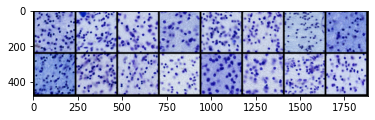

In [27]:
show_cluster(img_cluster,9)

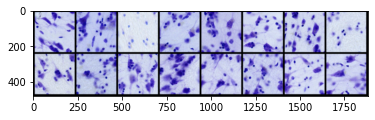

In [28]:
show_cluster(img_cluster,14)

Parse a whole NISSL slide
-----

In [29]:
osl=openslide.OpenSlide('/home/pyushkevich/data/raw/HNL-34-18_HR3a_NISSL_24.tif')

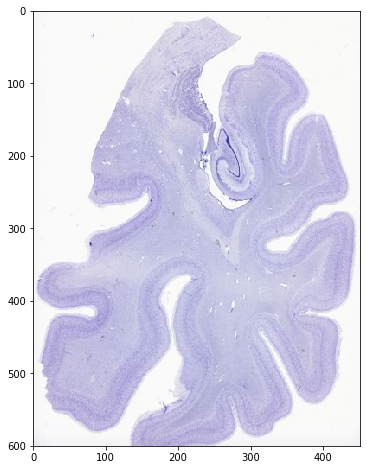

In [30]:
plt.figure(figsize=(16,8))
plt.imshow(osl.get_thumbnail((512,512)), extent=(0,osl.level_dimensions[0][0]/224,osl.level_dimensions[0][1]/224,0))
ax = plt.gca()
plt.xticks(np.arange(0,osl.level_dimensions[0][0]/224,100));
plt.yticks(np.arange(0,osl.level_dimensions[0][1]/224,100));

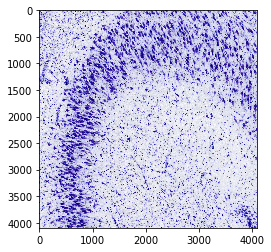

In [31]:
# Function to perform clustering on a window
window = osl.read_region((56000,44800),0,(4096,4096)).convert("RGB")
plt.imshow(window)

In [32]:
# Transforms for this
tran_norm = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [33]:
def run_model_on_window(model, window):
    W_patch = W.unfold(1,256,256).unfold(2,256,256).permute(1,2,0,3,4).reshape(-1,3,256,256)
    k = int(math.sqrt(W_patch.shape[0]))
    W_patch_crop = W_patch[:,:,16:240,16:240]
    with torch.no_grad():
        W_result = model(W_patch_crop)
    return W_result.reshape(k,k,W_result.shape[1])

In [34]:
import torch.nn
W=tran_norm(window).cuda()
R=run_model_on_window(model, W)
R.shape

torch.Size([16, 16, 20])

In [148]:
# Break the image into patches, for each patch, run the model on it
(w,h) = osl.level_dimensions[0]

# Size of the input window and number of windows
window_size=7168
nw_x,nw_y = math.ceil(w/window_size),math.ceil(h/window_size)

# Output window size and output dimensions
output_window_size = int(window_size / 256)
(ow,oh) = nw_x * output_window_size, nw_y * output_window_size
output = np.zeros((ow,oh,20))

for i_x in range(nw_x):
    for i_y in range(nw_y):
        
        # The corner of the region
        c_x,c_y = window_size * i_x, window_size * i_y
        window = osl.read_region((c_x,c_y), 0, (window_size,window_size)).convert("RGB")
        W=tran_norm(window).cuda()
        R=run_model_on_window(model, W).cpu().numpy().transpose((1,0,2))
        
        co_x,co_y = output_window_size * i_x, output_window_size * i_y
        output[co_x:co_x+output_window_size,co_y:co_y+output_window_size,:] = R
        
        print('Finished (%d,%d) of (%d,%d)' % (i_x,i_y,nw_x,nw_y))

Finished (0,0) of (15,20)
Finished (0,1) of (15,20)
Finished (0,2) of (15,20)
Finished (0,3) of (15,20)
Finished (0,4) of (15,20)
Finished (0,5) of (15,20)
Finished (0,6) of (15,20)
Finished (0,7) of (15,20)
Finished (0,8) of (15,20)
Finished (0,9) of (15,20)
Finished (0,10) of (15,20)
Finished (0,11) of (15,20)
Finished (0,12) of (15,20)
Finished (0,13) of (15,20)
Finished (0,14) of (15,20)
Finished (0,15) of (15,20)
Finished (0,16) of (15,20)
Finished (0,17) of (15,20)
Finished (0,18) of (15,20)
Finished (0,19) of (15,20)
Finished (1,0) of (15,20)
Finished (1,1) of (15,20)
Finished (1,2) of (15,20)
Finished (1,3) of (15,20)
Finished (1,4) of (15,20)
Finished (1,5) of (15,20)
Finished (1,6) of (15,20)
Finished (1,7) of (15,20)
Finished (1,8) of (15,20)
Finished (1,9) of (15,20)
Finished (1,10) of (15,20)
Finished (1,11) of (15,20)
Finished (1,12) of (15,20)
Finished (1,13) of (15,20)
Finished (1,14) of (15,20)
Finished (1,15) of (15,20)
Finished (1,16) of (15,20)
Finished (1,17) of (1

In [150]:
# The output comes out padded and transposed. Fix that
Z = output[0:math.ceil(w/256),0:math.ceil(h/256),:].transpose(1,0,2)


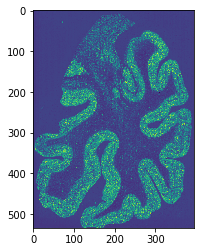

In [151]:
plt.imshow(Z[:,:,14])

In [138]:
Z.shape

(534, 395, 20)

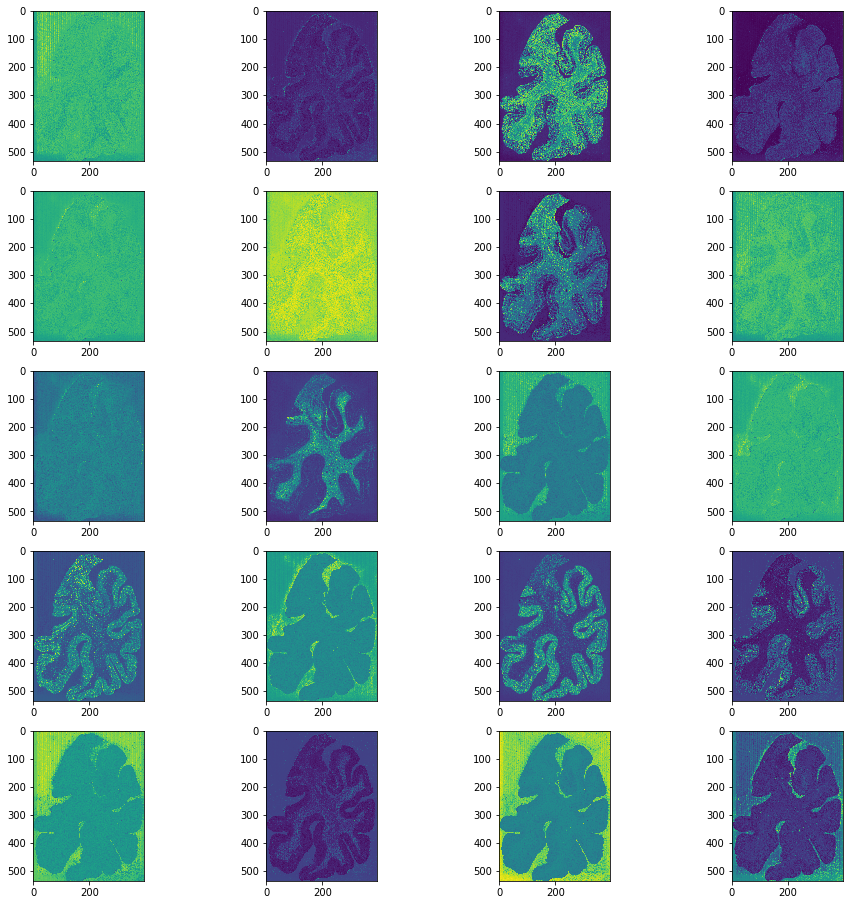

In [152]:
plt.figure(figsize=(16,16))
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(Z[:,:,i])

In [140]:
import scipy.cluster.vq
from sklearn import mixture

In [141]:
Z.reshape(-1,20).shape

(210930, 20)

In [142]:
g = mixture.GaussianMixture(n_components=3)
g.fit(Z.reshape(-1,20))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [143]:
prob = g.predict_proba(Z.reshape(-1,20)).reshape(Z.shape[0], Z.shape[1], 3)

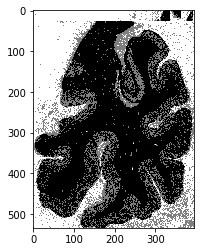

In [144]:
plt.imshow(prob[:,:,0] * 100 + prob[:,:,2] * 200, cmap='gray')